# Practical Project 

The aim of this project is to solve various forms of the portfolio optimization problem through Julia/computer software. This program template will provide hints/template code for you to focus on the optimization formulation part.

As usual, we first need to load a few packages in Julia.

In [1]:
# Load the JuMP related packages and several solvers
# ECOS - for solving SOCP problems
# GLPK - for solving IP/LP problems
using JuMP, ECOS, GLPK
# Load the data/file processing related packages
using CSV, Glob, DataFrames, Statistics
# Load the Plot package for illustrating the solution
using Plots
# Load the custom functions for benchmarking  
include("./reusablefunc.jl");

## Part I - Compulsory Task

#### Data Preprocessing
The first step is to load the raw data into the memory. To do so, we can directly apply the codes demonstrated during the computing lab as follows.

In [2]:
path_subgroup = "./ftec_project_subgroup1/"
files = glob( "*_train.csv", path_subgroup );
dfs = DataFrame.( CSV.File.( files ) );

In [3]:
T = 50; n = length(dfs);
stocks_retur = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    # we scale up the return 100 times
    stocks_retur[:,i] = (dfs[i].Close-dfs[i].Open) ./ dfs[i].Open*100;
end
names_stocks = [ dfs[i].Name[1] for i in 1:n ];



## Task 4: Warm-up Exercise

For part (a) of this task, you have to plot the return of 3-4 stocks over time. An example is provided for you as follows. Use "Insert" -> "Insert Cell Below/After" if you want to keep the plots together.

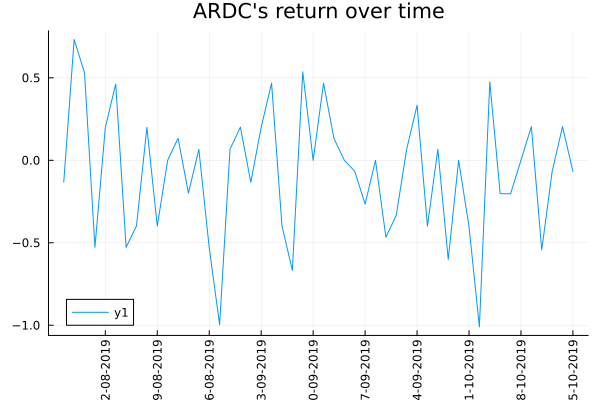

In [4]:
stock_id = 1;  # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].Date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time", xrotation = 90  )

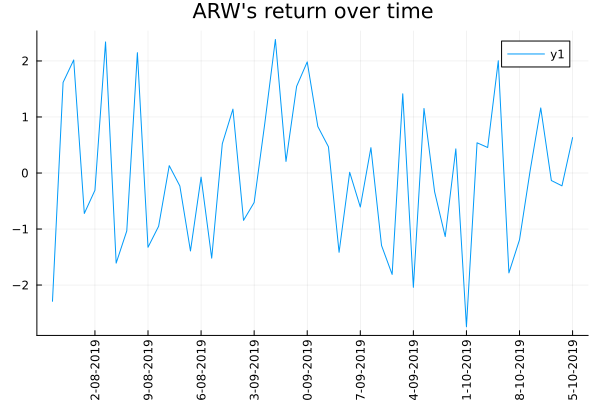

In [5]:
stock_id = 3; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].Date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time", xrotation = 90 )

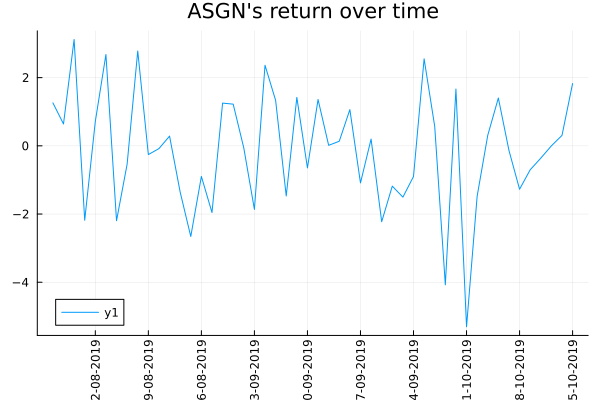

In [6]:
stock_id = 5; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].Date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time" ,xrotation = 90 )

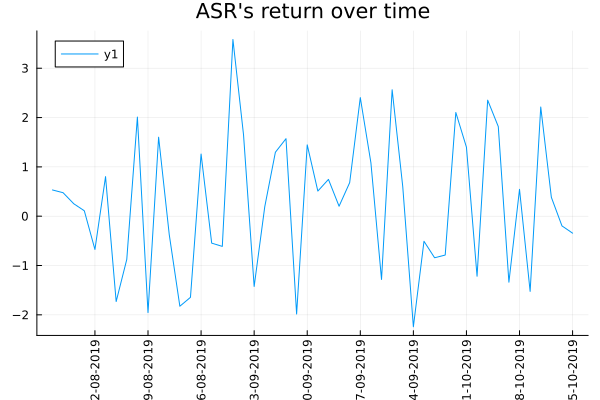

In [7]:
stock_id = 7; # You may change this stock_id to different numbers from 1 to 20
plot( dfs[stock_id].Date, stocks_retur[:,stock_id] , title = dfs[stock_id].Name[1]*"'s return over time" ,xrotation = 90 )

For part (b) of this task, we need to estimate the expected return $\hat{r}_i$ and covariance $\hat\rho_{ij}$. Notice that these terms are given by (1.3) in the project specification. For your convenience, they have been calculated as follows:

In [8]:
# calculate r_i and Sigma
bar_R = [ mean( stocks_retur[:,i] ) for i in 1:n ];
Sigma = [ mean( (stocks_retur[:,i].-bar_R[i]).*(stocks_retur[:,j].-bar_R[j]) ) for i=1:n, j=1:n ]; 

where "bar_R" is a $20$-dimensional vector containing the expected return $\hat{r}$ for the stocks; and "Sigma" is the $20 \times 20$ matrix of the covariance. 

## Task 5: Closed Form Solution to (1.1)

This task computes the optimal portfolio using the closed form solution derived in Task 1. Here are a few hints of useful syntax in computing the optimal solution:

- To compute the inverse of a square matrix, e.g., "$\texttt{Sigma}$", it can be done by 
$$\texttt{Sigma^-1}$$
- To create a (column) vector of all ones of $n$-dimensional. you may use 
$$\texttt{ones(n)}.$$ 
- In your closed form solution, you may need encounter something such as ${\bf 1}^\top {S} {b}$ for some $n \times n$ square matrix ${S}$, and $n$-dimensional vector ${b}$. The above expression can be computed in Julia as
$$\texttt{ones(n)'*S*b}$$
where $\texttt{ones(n)'}$ has denoted the transpose of the vector $\texttt{ones(n)}$. 

In [9]:
# your code here
l = 0.5
Rd = max(2,sum( bar_R ));
r1 = ones(20)'*Sigma^-1*bar_R
r2 = ones(20)'*Sigma^-1*ones(20)
B = 20
portfolio_opt = (1/(1.0)((Sigma^-1*((bar_R)+((1.0*B-r1)/(r2))*ones(20)))))'

20-element Vector{Float64}:
  0.06433170610672115
 -0.003934026480789691
 -0.001510714769851155
  0.00026205738346336154
 -0.015986806745226345
 -0.0015043068339437647
  0.003095513431634788
  0.00012781631832087936
  0.0045746431207414
 -0.0061380961573142545
  0.007085577076506137
  0.00018057259807965066
  0.010953348051812105
  0.0018375851254662779
  0.003237482458821138
  0.0002639501505019889
  0.010912574984669486
  0.0009551936731457244
  0.016751429819167832
  0.006763021323053064

Suppose that $\texttt{portfolio_opt}$ has been created as a 20-dimensional vector of the optimal portfolio. The following helper code should plot the comparison of the portfolio for you. 

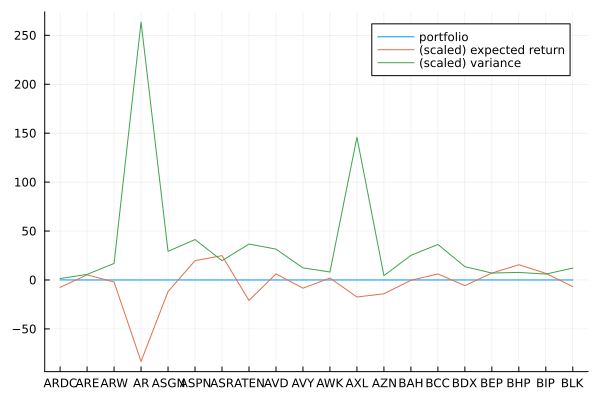

In [10]:
plot( names_stocks, portfolio_opt, labels = "portfolio", xticks = :all )
# you may adjust the scale factor "10" to scale up/down the expected return to make it comparable with 
# the value of the portfolio (*for improved visualization only*).
plot!( names_stocks, 100*bar_R, labels = "(scaled) expected return") 
plot!( names_stocks, 10*[Sigma[i,i] for i in 1:n], labels = "(scaled) variance" )

In [11]:
# Calculate the extreme value of lambda (from Task 1b)
# your code here
l_exme = (Rd-r1)/(r2*B)

0.007888057937417552

The following helper code should plot the comparison of the portfolio vs lambda for you . 

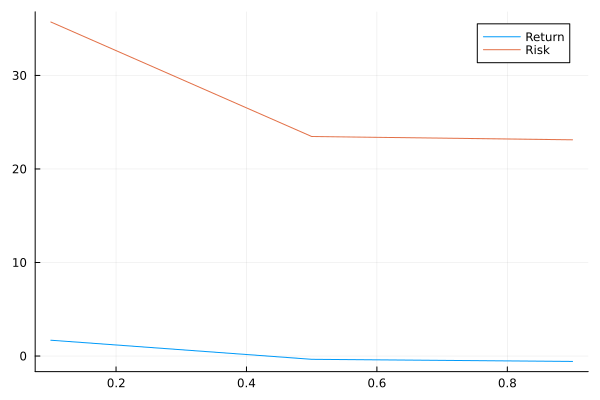

In [12]:
#Please try different value of lambda
#fill in the values of lambda that you want to try. Example: lambda = [0.1;0.2;0.3;0.4;0.5;0.6]
#your code here
lambda = [0.1; 0.5; 0.9] 
return_l = zeros(length(lambda));
risk_l = zeros(length(lambda));
for i = 1:length(lambda)
    #fill in the closed form solution written in Task 5(a). You can replace l with lambda[i] 
    portfolio = (1/(2*lambda[i]))*Sigma^-1*(bar_R + ((2*lambda[i]*B-r1)/r2)*ones(n))
    return_l[i] = sum(bar_R.*portfolio)
    risk_l[i] =  sum(portfolio'*Sigma*portfolio)   
end
plot(lambda,return_l, labels = "Return", xticks = :all )
plot!(lambda,risk_l, labels = "Risk", xticks = :all )

## Task 6 (a): Second-order cone programming solution

For this task, we shall implement the SOCP problem. As usual, we have to define the optimization object and specify a few parameters, as follows. The solver we are going to apply is "ECOS".

In [13]:
# specify the problem parameters - we have calculated the Rd, B, sqrt(Sigma) for you as follows
B = 20; Rd = max(2,sum( bar_R )); C = sqrt(Sigma);

You can program the SOCP problem in the following cell and solve it. Here are a few hints that maybe useful.

- To be compatible with the helper codes in the latter section, please call the decision variable for the portfolio by "x_socp
- You may use for-loop to specify a large number of constraints. 
- To model constraint given in the form of 
$$ \sum_{i=1}^n x_i y_i \geq r $$
withe the $n$-dimensional vectors $x$, $y$. You may do so by
$$ \texttt{@constraint(model, sum( x .* y ) >= r)} $$
where $\texttt{.*}$ denotes an "element-wise" product 
- To model a SOC constraint given in the form
$$ \| Ax + d \| \leq c^\top x + d, $$
you can use
$$ \texttt{ @constraint( m_socp, [c'*x + d; A*x + d] in SecondOrderCone() ) } $$
Essentially, "$\texttt{[c'*x + d; A*x + d]}$" defines a vector whose first element describes the RHS of the SOC constraint, the the remaining elements describe the vector found inside the norm of the SOC constraint. 


In [14]:
# specify the JuMP model with ECOS as the optimizer
m_socp = Model( ECOS.Optimizer );

# your code to specify the SOCP problem here
@variable( m_socp, x_socp[1:n] )

@constraint(m_socp, sum(x_socp) == B)
@constraint(m_socp, sum(bar_R .* x_socp) >= Rd )

for i = 1:n
    @constraint(m_socp, C*x_socp .>= 0)
end
@objective(m_socp, Min, 0.5 * sum(x_socp' * Sigma * x_socp))

# solve the SOCP problem below

optimize!(m_socp)


ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +3.258e-017  +4.258e+000  +3e+003  7e-001  8e+000  1e+000  6e+000    ---    ---    1  1  - |  -  - 
 1  +8.845e+001  +9.627e+001  +2e+003  5e-001  5e+000  5e+000  5e+000  0.6382  7e-001   1  1  1 |  0  0
 2  +2.075e+001  +2.221e+001  +3e+002  3e-002  3e-001  1e+000  8e-001  0.9526  1e-001   1  1  1 |  0  0
 3  +2.079e+001  +2.203e+001  +3e+002  4e-002  8e-002  1e+000  8e-001  0.2252  8e-001   1  2  2 |  0  0
 4  +1.531e+001  +1.559e+001  +6e+001  8e-003  1e-002  2e-001  2e-001  0.8231  4e-002   2  2  2 |  0  0
 5  +1.878e+001  +1.910e+001  +4e+001  1e-002  6e-003  3e-001  9e-002  0.6842  4e-001   2  2  2 |  0  0
 6  +1.912e+001  +1.917e+001  +9e+000  3e-003  1e-003  5e-002  2e-002  0.7915  7e-002   2  2  2 |  0  0
 7  +2.083e+001  +2.084e+001  +5e+000  1e-003  7e-004  1e-002  1e-002  0.6310  2e-001  

In [15]:
#The following helper code compute the Downside Risk Violation Probability and Average Downside Risk Violation for you.
downsiderisk( (JuMP.value.(x_socp)), T, stocks_retur,bar_R );

Prob. of Downside Risk Violation = 0.58, Amt. of Downside Risk Violation = 2.6001465256294676

## Task 6(b): Mixed Integer Programming Solution

For this task, we shall implement the MIP program formulated in Task 2. As usual, we have to define the optimization object and specify a few parameters, as follows. The solver we are going to apply is "GLPK" as we have introduced during the lecture.

In [16]:
# specify the problem parameters
# Tip: If you find that the solver takes too long time on optimization the problem, you can try a smaller M.
# Notice that reducing M can speedup the solver, but may result in an "infeasible solution" error
M = 40; B = 20;  w = 1*ones(n); Rd = max(2,sum( bar_R )); 

In [17]:
# specify the JuMP model with GLPK as the optimizer
m_ilp = Model(GLPK.Optimizer);
set_optimizer_attribute(m_ilp, "msg_lev", GLPK.GLP_MSG_ALL);

# your code to specify the MIP here

@variable(m_ilp, x_ilp[1:n])
@variable(m_ilp, z[1:T])
@objective(m_ilp, Min, sum(z[1:2]))
@constraint(m_ilp, sum(x_ilp[i]  * bar_R[i] for i in 1:n) - Rd >= 0)
@constraint(m_ilp, B - sum(x_ilp[i] for i in 1:n) <= 0)
for t=1:T
    @constraint(m_ilp, x_ilp[i] <= M(1-z[1:T])
end
     @constraint(m_ilp, (x_mip[i] + w[i] for i in 1:n) >= 0)
# solve the MIP
optimize!(m_ilp)

LoadError: syntax: missing comma or ) in argument list

In [18]:
downsiderisk( (JuMP.value.(x_ilp)), T, stocks_retur,bar_R );

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\Ruhi Chopra\.julia\packages\JuMP\yYfHy\src\optimizer_interface.jl:712


LoadError: OptimizeNotCalled()

## Task 6(c): Linear Programming Solution

For this task, we shall implement the LP program formulated in Task 3. As usual, we have to define the optimization object and specify a few parameters, as follows. The solver we are going to apply is "GLPK" as we have introduced during the lecture.

#### LP Solution

In [19]:
# specify the problem parameters
B = 20; w = 1*ones(n); Rd = max(2,sum( bar_R ));

In [20]:
# specify the JuMP model with GLPK as the optimizer
m_lp = Model( GLPK.Optimizer );
set_optimizer_attribute(m_lp, "msg_lev", GLPK.GLP_MSG_ALL);

# your code to specify the LP problem here
@variable( m_lp, x_lp[1:n] )
@constraint(m_lp, sum(x_lp) == B)
@objective(m_lp, Min, sum((1/T)*sum(stocks_retur[:, i].*x_lp[i]) - bar_R[i] for i in 1:n))


# solve the LP
optimize!(m_lp)

GLPK Simplex Optimizer 5.0
1 row, 20 columns, 20 non-zeros
      0: obj =  8.466368035e-001 inf =  2.000e+001 (1)
      1: obj = -6.693533155e-001 inf =  0.000e+000 (0)
LP HAS UNBOUNDED PRIMAL SOLUTION


In [21]:
downsiderisk( (JuMP.value.(x_lp)), T, stocks_retur,bar_R );

Prob. of Downside Risk Violation = 0.56, Amt. of Downside Risk Violation = 2.1599906900094847

## Task 6(d): Plotting the portfolios found

Given that you have programmed and executed the optimization problems correctly, the following helper code shall plot the portfolios nicely for you. 

In [22]:
plot( names_stocks, portfolio_opt,lc=:red, labels = "unconstrained portfolio" )
plot!(names_stocks, JuMP.value.(x_socp),lc=:orange, labels = "SOCP" )
plot!( names_stocks, JuMP.value.(x_ilp),lc=:green, labels = "MI-LP")
plot!( names_stocks, JuMP.value.(x_lp),lc=:purple, labels = "LP")
plot!( names_stocks, 5*bar_R,lc=:black, labels ="(Scaled) Expected Return")
plot!( names_stocks, 0.5*[Sigma[i,i] for i in 1:n],lc=:blue, labels ="(Scaled) Variance")
plot!(legend=:topright)

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\Ruhi Chopra\.julia\packages\JuMP\yYfHy\src\optimizer_interface.jl:712


LoadError: OptimizeNotCalled()

## Task 7: Evaluating the Solution on Testing Set

Again, provided that you have programmed and executed the optimization problems correctly, the following helper code shall compute the Sharpe ratio and other benchmarks for you.

In [23]:
Perfor_Opt = performance_testdata( path_subgroup, portfolio_opt[:,1], 796,bar_R/100 );

Sharpe Ratio = 0.03465686370238847, Prob. of Downside Risk Violation = 0.4723618090452261, Amt. of Downside Risk Violation = 0.00030158198800317497, Return = 3.961412351343876e-5, Portfo Value = 0.10225852063497975

In [24]:
Perfor_SOCP = performance_testdata( path_subgroup, (JuMP.value.(x_socp)), 796,bar_R/100 );

Sharpe Ratio = 0.04930639423835307, Prob. of Downside Risk Violation = 0.4962311557788945, Amt. of Downside Risk Violation = 0.07619737266819693, Return = 0.011135340661976688, Portfo Value = 19.999999999999947

In [25]:
Perfor_IP = performance_testdata( path_subgroup, JuMP.value.(x_ilp), 796,bar_R/100 );

┌ Warning: The model has been modified since the last call to `optimize!` (or `optimize!` has not been called yet). If you are iteratively querying solution information and modifying a model, query all the results first, then modify the model.
└ @ JuMP C:\Users\Ruhi Chopra\.julia\packages\JuMP\yYfHy\src\optimizer_interface.jl:712


LoadError: OptimizeNotCalled()

In [26]:
Perfor_LP = performance_testdata( path_subgroup, JuMP.value.(x_lp) , 796,bar_R/100 );

Sharpe Ratio = 0, Prob. of Downside Risk Violation = 0.44221105527638194, Amt. of Downside Risk Violation = 0.014659736155668625, Return = 0.0009194406602996246, Portfo Value = 0.0

# Part II - Competitive Task

In the compulsory task, we shall implement a projected gradient method (or any other gradient-type algorithm) for the approximated Portfolio optimization problem. 

We shall consider the portfolio optimization problem on the full dataset. For this, let us first load the data with the following helper code.

In [27]:
# load the full data set!
files = glob( "*_train.csv", "./ftec_project_files/");
dfs = DataFrame.( CSV.File.( files ) );
T = 799; n = length(dfs);
stocks_retur_full = zeros(T,n);
for i = 1:n
    # compute the realized return R_i(t)
    stocks_retur_full[:,i] = (dfs[i].Close-dfs[i].Open) ./ dfs[i].Open;
end
names_stocks_full = [ dfs[i].Name[1] for i in 1:n ];
# calculate r_i and Sigma
bar_R_full = [ mean( stocks_retur_full[:,i] ) for i in 1:length(dfs) ];
Sigma_full = [ mean( (stocks_retur_full[:,i].-bar_R_full[i]).*(stocks_retur_full[:,j].-bar_R_full[j]) ) for i=1:n, j=1:n ];

Notice that "bar_R_full" is the expected return for all the $n=699$ stocks considered, and "Sigma_full" is the $699 \times 699$ covariance matrix for them. 

## Task 8: Implementing a Customized Solver for the approximated problem

You may wish to write a few helper functions to compute the objective values, the gradient vector, the projection into the box constraint, etc.. to help you with implementing the customized solver. Some useful syntax are as follows:

- For a nonlinear function $h(z)$ (such as the Huber function) on a scalar $z$. Suppose that $x$ is an $n$-dimensional vector, to create the vector 
$$ [h(x)]_i = h(x_i) $$
you may use the syntax
$$ \texttt{h.(x)} $$
where the "." after "h" broadcasts the function to every elements of the vector. 

You may program the iterative algorithm of your choice as follows. 

In [28]:
# your code/functions here - below is a recommendation on what functions you may develop to help yourself

# define the Huber functions & its derivative 
function huber_fct(x, delta)
    abs_x = abs.(x)
    ifelse.( abs_x .<= delta, 0.5 .* x.^2, delta .* (abs_x .- 0.5 .* delta))
end



huber_fct (generic function with 1 method)

In [29]:
function derivative_huber_fct(x, delta)
    abs_x = abs.(x)
    ifelse.( abs_x .<= delta, x, delta .* sign.(x))
end

derivative_huber_fct (generic function with 1 method)

In [30]:
# objective function and its gradient 
function obj_fct(x, stocks_retur_full, bar_R, upsilon, gamma, delta)
    xminusbar = x .- bar_R
    f1 = 0.5 .* dot(xminusbar, Sigma_full * xminusbar)
    f2 = upsilon .* sum(huber_fct.(x, delta))
    f3 = 0.5 .* gamma .* dot(x, x)
    f1 + f2 + f3
end

obj_fct (generic function with 1 method)

In [31]:
function grd_obj(x, stocks_retur_full, bar_R, upsilon, gamma, delta)
    xminusbar = x .- bar_R
    g1 = Sigma_full * xminusbar
    g2 = derivative_huber_fct(x, delta)
    g3 = gamma .* x
    g1 .+ upsilon .* g2 .+ g3
end


grd_obj (generic function with 1 method)

In [32]:
# projection into [v,u]
function projection_box(x, v, u)
    max.(v, min.(u, x))
end

projection_box (generic function with 1 method)

In [36]:
# set the parameters in the optimization problem - below are some "suggested values" only, feel free to 
# tune them to achieve better performance when needed
upsilon = 2000
gamma = 1
delta = 0.1

# initialize the algorithm
x_gd = zeros(n)
v = -0.2 * ones(n)
u = 0.2 * ones(n)
x_gd = projection_box(x_gd, v, u)



store_obj = []
push!(store_obj, obj_fct(x_gd, stocks_retur_full, bar_R_full, upsilon, gamma, delta))
    
for iteration_no = 1:5000 # feel free to adjust the number of iterations (make sure that it's >= 5000)
    # gradient step
    x_gd = x_gd - 0.005 .* grd_obj(x_gd, stocks_retur_full, bar_R_full, upsilon, gamma, delta)
    # projection step
    x_gd = projection_box(x_gd, v, u)
    push!(store_obj, obj_fct(x_gd, stocks_retur_full, bar_R_full, upsilon, gamma, delta))
end
plot( store_obj , title = "objective value")

LoadError: UndefVarError: dot not defined

The following helper code return you the Downside Risk Violation Probability and Average Downside Risk Violation on training data.

In [37]:
downsiderisk( x_gd, T, stocks_retur_full,bar_R_full )

Prob. of Downside Risk Violation = 0.0, Amt. of Downside Risk Violation = 0.0

1×2 Matrix{Float64}:
 0.0  0.0

The following code computes the sharpe ratio, return, downside risk violation probability and average downside risk violation which will be used to calculate your score for the competitive task!

In [38]:
perfor_GD = performance_testdata( "./ftec_project_files/", x_gd , 447, bar_R_full );

Sharpe Ratio = 0, Prob. of Downside Risk Violation = 0.0, Amt. of Downside Risk Violation = 0.0, Return = 0.0, Portfo Value = 0.0